## Import Dependencies

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn as skl
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\otrin\.conda\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\otrin\.conda\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\otrin\.conda\envs\PythonData\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\otrin\.conda\envs\PythonData\lib\site-packages\tensorflow\

## Explore the Data

In [2]:
# Import Data File
charity_df = pd.read_csv('charity_data.csv')
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
## Find duplicate entries, if any.
print(f"Duplicate entries: {charity_df.duplicated().sum()}")

Duplicate entries: 0


In [4]:
#Inspect data types
charity_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

In [5]:
# Find null values, if any.
for column in charity_df.columns:
    print(f"{column} has {charity_df[column].isnull().sum()} null values")

EIN has 0 null values
NAME has 0 null values
APPLICATION_TYPE has 0 null values
AFFILIATION has 0 null values
CLASSIFICATION has 0 null values
USE_CASE has 0 null values
ORGANIZATION has 0 null values
STATUS has 0 null values
INCOME_AMT has 0 null values
SPECIAL_CONSIDERATIONS has 0 null values
ASK_AMT has 0 null values
IS_SUCCESSFUL has 0 null values


In [6]:
## Find duplicate entries, if any.
print(f"Duplicate entries: {charity_df.duplicated().sum()}")

Duplicate entries: 0


In [7]:
# Drop EIN columns and use name as the unique identifiers
charity_df = charity_df.drop(["EIN"], 1)

## Pre-process the data

In [8]:
## Convert all categorical values 
charity_cat = charity_df.dtypes[charity_df.dtypes =="object"].index.tolist()
charity_df[charity_cat].nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
dtype: int64

In [9]:
#Investigate classification values to determine if binning is required 
classification_count = charity_df['CLASSIFICATION'].value_counts()
classification_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C6100        1
C3700        1
C2380        1
C2190        1
C2561        1
Name: CLASSIFICATION, Length: 71, dtype: int64

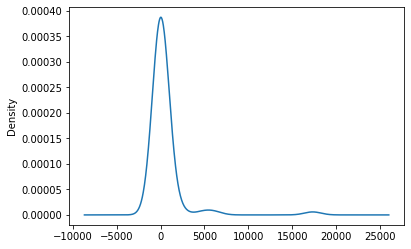

In [10]:
# Due to the uneven distribution of CLASSIFICATION, will bucket the rare values into "other" category 
classification_count.plot.density()

In [11]:
# Based on density map, will bucket all values under 1000 into others 

bucket_classification = list(classification_count[classification_count<1000].index)
for classification in bucket_classification: 
    charity_df["CLASSIFICATION"] = charity_df["CLASSIFICATION"].replace(classification, "Other")

charity_df["CLASSIFICATION"].value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [12]:
#Check "Application Type" with 17 unique values to see if bucketing is needed 
application = charity_df["APPLICATION_TYPE"].value_counts()
application

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [13]:
#Check name column
names = charity_df.NAME.value_counts()
names

PARENT BOOSTER USA INC                                          1260
TOPS CLUB INC                                                    765
UNITED STATES BOWLING CONGRESS INC                               700
WASHINGTON STATE UNIVERSITY                                      492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                  408
                                                                ... 
GREATER BOISE PUG RESCUE AND PLACEMENT GROUP                       1
ARROW SPACE FOR FAMILIES INC                                       1
ATLANTA RONALD MCDONALD HOUSE CHARITIES INC                        1
OKLAHOMA FAMILY LEGAL ADVOCATES INC                                1
MONSIGNOR DOMINIC BLASCO COUNCIL NO 3298 KNIGHTS OF COLUMBUS       1
Name: NAME, Length: 19568, dtype: int64

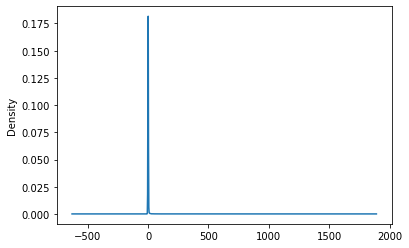

In [14]:
names.plot.density()

In [15]:
#bucket names 
bucket_names = list(names[names<100].index)
for name in bucket_names: 
    charity_df["NAME"] = charity_df["NAME"].replace(name, "Other")

charity_df["NAME"].value_counts()

Other                                                                 25987
PARENT BOOSTER USA INC                                                 1260
TOPS CLUB INC                                                           765
UNITED STATES BOWLING CONGRESS INC                                      700
WASHINGTON STATE UNIVERSITY                                             492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                         408
PTA TEXAS CONGRESS                                                      368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                           331
ALPHA PHI SIGMA                                                         313
TOASTMASTERS INTERNATIONAL                                              293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                       287
LITTLE LEAGUE BASEBALL INC                                              277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                                266
MOMS CLUB   

In [16]:
# encode all categorical values 
enc = OneHotEncoder(sparse = False)
encode_df = pd.DataFrame(enc.fit_transform(charity_df[charity_cat]))
encode_df.columns = enc.get_feature_names(charity_cat)
encode_df.head()

,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CIVITAN INTERNATIONAL,NAME_DEMOLAY INTERNATIONAL,NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA,NAME_HABITAT FOR HUMANITY INTERNATIONAL INC,NAME_HONOR SOCIETY OF PHI KAPPA PHI,NAME_INTERNATIONAL ASSOCIATION OF LIONS CLUBS,NAME_INTERNATIONAL ASSOCIATION OF SHEET METAL AIR RAIL & TRANSPORTATION,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
#Merge the encoded dataframe back into main dataframe, drop the converted columns 
charity_df = charity_df.merge(encode_df, left_index = True, right_index = True)
charity_df = charity_df.drop(charity_cat, 1)

In [18]:
#split dataset into training and testing data. The target is to predict if the money is used effectively, so "IS_SUCESSFUL"
#will be the target 

y = charity_df['IS_SUCCESSFUL'].values
X=charity_df.drop("IS_SUCCESSFUL", axis = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)


In [20]:
# standardize the data 
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Try Random Forest Classifier

In [21]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.739


## Try Neural Network

In [22]:
#build neural network. The total number of rows is over 36,000, with 36 input dimensions.  Because of the large number of 
#input dimensions, I will build a neural network with 2 layers, first layer with 10 units and second with 8

input_features = len(X_train_scaled[0])
nodes_layer1 = 10
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = nodes_layer1, input_dim = input_features, activation = "relu"))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = "relu"))
nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
#train the model 
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 22us/sample - loss: 0.5606 - acc: 0.7065
Epoch 2/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.5029 - acc: 0.7510
Epoch 3/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4957 - acc: 0.7547
Epoch 4/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4928 - acc: 0.7566
Epoch 5/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4914 - acc: 0.7569
Epoch 6/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4898 - acc: 0.7579
Epoch 7/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4894 - acc: 0.7576
Epoch 8/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4884 - acc: 0.7593
Epoch 9/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4882 - acc: 0.7577
Epoch 10/50
25724/25724 [==============================] - 0s 19us/sample - loss: 

### Accuracy at 75%, try optimizing


## Optimization 1: Look at outliers for the ASK_AMT variable to decrease noise

In [24]:
#Look at outliers for the ASK_AMT variable
amount = X.ASK_AMT.value_counts()
amount

5000       25398
10478          3
15583          3
6725           3
63981          3
           ...  
772556         1
70103          1
27096          1
25049          1
1138700        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [25]:
# Identify unique values
X.ASK_AMT.nunique()

8747

In [26]:
#There are over 8,000 unique values we'll bucket the values so that those less than 25000 will be grouped together 
bucket_amount = list(amount[amount<25000].index)
for amt in bucket_amount: 
    X["ASK_AMT"] = X['ASK_AMT'].replace(amt, "Other")
X.ASK_AMT.value_counts()

5000     25398
Other     8901
Name: ASK_AMT, dtype: int64

In [27]:
X["ASK_AMT"] = X["ASK_AMT"].astype(str)
encode_amount = pd.DataFrame(enc.fit_transform(X["ASK_AMT"].values.reshape(-1,1)))
encode_amount.columns = enc.get_feature_names(['ASK_AMT'])
encode_amount.head()

,ASK_AMT_5000,ASK_AMT_Other
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


In [28]:
X = X.merge(encode_amount, left_index = True, right_index = True)

In [29]:
# Drop ASK_AMT
X=X.drop('ASK_AMT',1)
X.head()

,STATUS,NAME_ALPHA PHI SIGMA,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ASSOCIATION OF UNIVERSITY WOMEN,NAME_CIVITAN INTERNATIONAL,NAME_DEMOLAY INTERNATIONAL,NAME_FARMERS EDUCATIONAL AND COOPERATIVE UNION OF AMERICA,NAME_HABITAT FOR HUMANITY INTERNATIONAL INC,NAME_HONOR SOCIETY OF PHI KAPPA PHI,NAME_INTERNATIONAL ASSOCIATION OF LIONS CLUBS,...,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_5000,ASK_AMT_Other
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [30]:
#Re-split, re-scale, and re-build the model with new dataset 
#Resplit 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Rescale
input_features = len(X_train_scaled[0])
nodes_layer1 = 10
nodes_layer2 = 8

In [32]:
# Remodel
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = nodes_layer1, input_dim = input_features, activation = "relu"))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = "relu"))
nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [33]:
# Refit
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 22us/sample - loss: 0.5647 - acc: 0.7112
Epoch 2/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.5053 - acc: 0.7432
Epoch 3/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4972 - acc: 0.7498
Epoch 4/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4942 - acc: 0.7521
Epoch 5/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4926 - acc: 0.7528
Epoch 6/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4916 - acc: 0.7548
Epoch 7/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4909 - acc: 0.7566
Epoch 8/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4897 - acc: 0.7573
Epoch 9/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4886 - acc: 0.7575
Epoch 10/50
25724/25724 [==============================] - 0s 19us/sample - loss: 

### Accuracy minimally lowered

## Optimization 2: Try adding more neurons to first layer (10 -> 20) 

In [34]:
new_nodes_layer1 = 20
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = "relu"))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = "relu"))
nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 23us/sample - loss: 0.5419 - acc: 0.7252
Epoch 2/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4992 - acc: 0.7495
Epoch 3/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4933 - acc: 0.7544
Epoch 4/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4904 - acc: 0.7563
Epoch 5/50
25724/25724 [==============================] - 0s 19us/sample - loss: 0.4885 - acc: 0.7576
Epoch 6/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4872 - acc: 0.7570
Epoch 7/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4862 - acc: 0.7580
Epoch 8/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4853 - acc: 0.7584
Epoch 9/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4842 - acc: 0.7588
Epoch 10/50
25724/25724 [==============================] - 1s 20us/sample - loss: 

## Optimization 3: Try adding more neurons to second layer (8 -> 12)


In [35]:
new_nodes_layer1 = 20
new_nodes_layer2 = 12

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = "relu"))
nn.add(tf.keras.layers.Dense(units = new_nodes_layer2, activation = "relu"))
nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 23us/sample - loss: 0.5294 - acc: 0.7305
Epoch 2/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4964 - acc: 0.7548
Epoch 3/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4923 - acc: 0.7553
Epoch 4/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4896 - acc: 0.7566
Epoch 5/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4884 - acc: 0.7573
Epoch 6/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4868 - acc: 0.7578
Epoch 7/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4859 - acc: 0.7589
Epoch 8/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4852 - acc: 0.7594
Epoch 9/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4846 - acc: 0.7600
Epoch 10/50
25724/25724 [==============================] - 1s 20us/sample - loss: 

## Optimization 4: Try a different activation method with 12 layer2 nodes (Relu to LeakyRelu)

#### 4.1 Maintain the previously tried node settings in Optimization 2 with different activation method

In [36]:
new_nodes_layer1 = 20
nodes_layer2 = 12

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 23us/sample - loss: 0.5292 - acc: 0.7295
Epoch 2/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4984 - acc: 0.7464
Epoch 3/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4949 - acc: 0.7518
Epoch 4/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4932 - acc: 0.7541
Epoch 5/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4918 - acc: 0.7557
Epoch 6/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4905 - acc: 0.7577
Epoch 7/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4890 - acc: 0.7588
Epoch 8/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4887 - acc: 0.7573
Epoch 9/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4880 - acc: 0.7588
Epoch 10/50
25724/25724 [==============================] - 1s 20us/sample - loss: 

####  Slight improvement!

### 4.2 Go back to original node ratio of 20 : 8 with different activation method

In [37]:
# 3.2 Go back to original node ratio of 20 : 8 with different activation method
new_nodes_layer1 = 20
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 23us/sample - loss: 0.5322 - acc: 0.7262
Epoch 2/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4968 - acc: 0.7512
Epoch 3/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4934 - acc: 0.7563
Epoch 4/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4910 - acc: 0.7563
Epoch 5/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4903 - acc: 0.7575
Epoch 6/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4897 - acc: 0.7566
Epoch 7/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4886 - acc: 0.7584
Epoch 8/50
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4881 - acc: 0.7588
Epoch 9/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4876 - acc: 0.7580
Epoch 10/50
25724/25724 [==============================] - 1s 20us/sample - loss: 

#### Accuracy increased compared to 4.1 optimization

### Visualize Loss and Accuracy of the Most Accurate Model


In [38]:
# Create a DataFrame containing training the history of the loss and accuracy history.
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

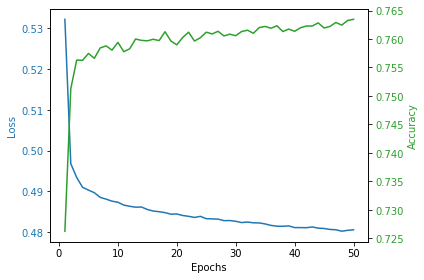

In [39]:
# Create the plot visualizing that as the loss is reduced the accuracy increases over each epoch.
loss_test = history_df['loss']
accur_test = history_df['acc']
epochs = range(1,200)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis.

color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(accur_test, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Ensuring the right y-label is not slightly clipped.
plt.show()

## Optimization 4: Increase Number of Epochs 

In [40]:
# Double Training epochs (50 to 100)
new_nodes_layer1 = 20
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 100)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
25724/25724 [==============================] - 1s 25us/sample - loss: 0.5381 - acc: 0.7296
Epoch 2/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4997 - acc: 0.7491
Epoch 3/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4951 - acc: 0.7538
Epoch 4/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4940 - acc: 0.7554
Epoch 5/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4915 - acc: 0.7570
Epoch 6/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4906 - acc: 0.7564
Epoch 7/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4899 - acc: 0.7566
Epoch 8/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4885 - acc: 0.7572
Epoch 9/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4883 - acc: 0.7580
Epoch 10/100
25724/25724 [==============================] - 1s 21us/sampl

25724/25724 [==============================] - 1s 20us/sample - loss: 0.4786 - acc: 0.7649
Epoch 80/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4783 - acc: 0.7640
Epoch 81/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4781 - acc: 0.7650
Epoch 82/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4783 - acc: 0.7622
Epoch 83/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4782 - acc: 0.7646
Epoch 84/100
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4779 - acc: 0.7635
Epoch 85/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4780 - acc: 0.7644
Epoch 86/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4780 - acc: 0.7647
Epoch 87/100
25724/25724 [==============================] - 1s 20us/sample - loss: 0.4775 - acc: 0.7652
Epoch 88/100
25724/25724 [==============================] - 1s 20us/sample - 

#### Doubling the training epochs lowerred the accuracy (not a good idea)

In [41]:
# Increase the Epoch from 50 to 75
new_nodes_layer1 = 20
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = tf.keras.layers.LeakyReLU(alpha=0.3)))

nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 75)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/75
25724/25724 [==============================] - 1s 24us/sample - loss: 0.5262 - acc: 0.7338
Epoch 2/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4976 - acc: 0.7550
Epoch 3/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4942 - acc: 0.7565
Epoch 4/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4928 - acc: 0.7572
Epoch 5/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4916 - acc: 0.7570
Epoch 6/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4907 - acc: 0.7571
Epoch 7/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4897 - acc: 0.7579
Epoch 8/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4892 - acc: 0.7569
Epoch 9/75
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4889 - acc: 0.7566
Epoch 10/75
25724/25724 [==============================] - 1s 21us/sample - loss: 

#### Increasing by only 25 epochs got it back up to 75% accuracy but still less than optimization 4.2

## Optimization 4: Decrease alpha to 0.1

In [42]:
new_nodes_layer1 = 20
nodes_layer2 = 8

nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(units = new_nodes_layer1, input_dim = input_features, activation = tf.keras.layers.LeakyReLU(alpha=0.1)))
nn.add(tf.keras.layers.Dense(units = nodes_layer2, activation = tf.keras.layers.LeakyReLU(alpha=0.1)))

nn.add(tf.keras.layers.Dense(units =1, activation = "sigmoid"))
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
fit_model = nn.fit(X_train_scaled, y_train, epochs = 50)
#evaluate model accuracy
model_loss, model_accuracy =nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
25724/25724 [==============================] - 1s 25us/sample - loss: 0.5440 - acc: 0.7284
Epoch 2/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4985 - acc: 0.7551
Epoch 3/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4931 - acc: 0.7553
Epoch 4/50
25724/25724 [==============================] - 1s 22us/sample - loss: 0.4915 - acc: 0.7573
Epoch 5/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4899 - acc: 0.7575
Epoch 6/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4888 - acc: 0.7581
Epoch 7/50
25724/25724 [==============================] - 1s 22us/sample - loss: 0.4879 - acc: 0.7581
Epoch 8/50
25724/25724 [==============================] - 1s 21us/sample - loss: 0.4877 - acc: 0.7588
Epoch 9/50
25724/25724 [==============================] - 1s 22us/sample - loss: 0.4871 - acc: 0.7582
Epoch 10/50
25724/25724 [==============================] - 1s 21us/sample - loss: 

## Try Random Forest Model

In [45]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.754


## Try Logistic Regression

In [44]:
# Define the logistic regression model
log_classifier = LogisticRegression(solver="lbfgs",max_iter=1000)

# Train the model
log_classifier.fit(X_train,y_train)

# Evaluate the model
y_pred = log_classifier.predict(X_test)
print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Logistic regression model accuracy: 0.739


# Summary: It looks like Optimization 4.2 is the best so far, please look at the visualization for this Optimization.